# Logistic Regression — Heart Disease (Framingham)

Building a transparent, reproducible baseline for 10-year CHD risk classification.

**Dataset:** `framingham.csv` (demographic, behavioral, medical)  
**Target:** `TenYearCHD` (0 = no CHD event in 10 years, 1 = CHD event)

In [49]:
# ─────────────────────────────────────────────────────────────────────────────
# Environment and reproducibility setup
# Imports, seeds, and device configuration (PyTorch used later for modeling).
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

import os
import random
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import json
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import torch.optim as optim

try:
    import torch
except ImportError as e:
    raise ImportError(
        "PyTorch is required. Install via `pip install torch --index-url https://download.pytorch.org/whl/cu121` "
        "or any version matching the local CUDA/CPU setup."
    ) from e


def set_global_seeds(seed: int = 42) -> None:
    """Setting random seeds for Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(False)  # faster baseline (not fully deterministic)


def get_device() -> torch.device:
    """Selecting the appropriate computation device (CPU or CUDA)."""
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def print_versions() -> None:
    """Printing library versions for traceability."""
    print(f"Python: {os.sys.version.split()[0]}")
    print(f"Pandas: {pd.__version__}")
    print(f"NumPy:  {np.__version__}")
    print(f"Torch:  {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")


SEED = 42
set_global_seeds(SEED)
DEVICE = get_device()
print_versions()
print(f"Using device: {DEVICE}")


Python: 3.12.12
Pandas: 2.3.3
NumPy:  2.3.4
Torch:  2.9.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5070 Ti Laptop GPU
Using device: cuda


## Raw data inspection

Loading the CSV, previewing the first rows, and inspecting dtypes/nulls before defining any schema.  
This verifies file access, column names, and potential data issues.

In [21]:
csv_path = "../data/framingham.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
display(df.head(5))
df.info()

Shape: (4238, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [22]:
# ─────────────────────────────────────────────────────────────────────────────
# Missing values and descriptive statistics
# ─────────────────────────────────────────────────────────────────────────────
# Missing per column
display(df.isna().sum().to_frame("missing").T)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
missing,0,0,105,0,29,53,0,0,0,50,0,0,19,1,388,0


In [23]:
# Numeric descriptives
display(df.describe(include=[np.number]).T)

,count,mean,std,min,25%,50%,75%,max
male,4238.0,0.429212,0.495022,0.00,0.00,0.0,1.000,1.0
age,4238.0,49.584946,8.572160,32.00,42.00,49.0,56.000,70.0
education,4133.0,1.978950,1.019791,1.00,1.00,2.0,3.000,4.0
currentSmoker,4238.0,0.494101,0.500024,0.00,0.00,0.0,1.000,1.0
cigsPerDay,4209.0,9.003089,11.920094,0.00,0.00,0.0,20.000,70.0
BPMeds,4185.0,0.029630,0.169584,0.00,0.00,0.0,0.000,1.0
prevalentStroke,4238.0,0.005899,0.076587,0.00,0.00,0.0,0.000,1.0
prevalentHyp,4238.0,0.310524,0.462763,0.00,0.00,0.0,1.000,1.0
diabetes,4238.0,0.025720,0.158316,0.00,0.00,0.0,0.000,1.0
totChol,4188.0,236.721585,44.590334,107.00,206.00,234.0,263.000,696.0


In [24]:
# ─────────────────────────────────────────────────────────────────────────────
# Value counts for important binary/categorical columns
# ─────────────────────────────────────────────────────────────────────────────
key_cols = [
    "TenYearCHD", "male", "currentSmoker", "BPMeds", "prevalentStroke",
    "prevalentHyp", "diabetes", "education"
]
for col in key_cols:
    if col in df.columns:
        print(f"\n{col} — top values:")
        display(df[col].value_counts(dropna=False).head().to_frame("count"))



TenYearCHD — top values:


,count
TenYearCHD,
0,3594
1,644



male — top values:


,count
male,
0,2419
1,1819



currentSmoker — top values:


,count
currentSmoker,
0,2144
1,2094



BPMeds — top values:


,count
BPMeds,
0.0,4061
1.0,124
NaN,53



prevalentStroke — top values:


,count
prevalentStroke,
0,4213
1,25



prevalentHyp — top values:


,count
prevalentHyp,
0,2922
1,1316



diabetes — top values:


,count
diabetes,
0,4129
1,109



education — top values:


,count
education,
1.0,1720
2.0,1253
3.0,687
4.0,473
NaN,105


In [25]:
# ─────────────────────────────────────────────────────────────────────────────
# Plotting setup
# ─────────────────────────────────────────────────────────────────────────────
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["figure.dpi"] = 100

plots_dir = Path("../artifacts/plots")
plots_dir.mkdir(parents=True, exist_ok=True)
print("Saving plots to:", plots_dir.resolve())

Saving plots to: C:\Users\Zakaria\Downloads\heart-disease-prediction\artifacts\plots


In [26]:
target_col = "TenYearCHD"
binary_cols = ["male", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]
numeric_cols = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]
ordinal_cols = ["education"]  # 1–4

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2938400211.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=target_col, data=df, palette=["#86BBD8", "#E07A5F"])


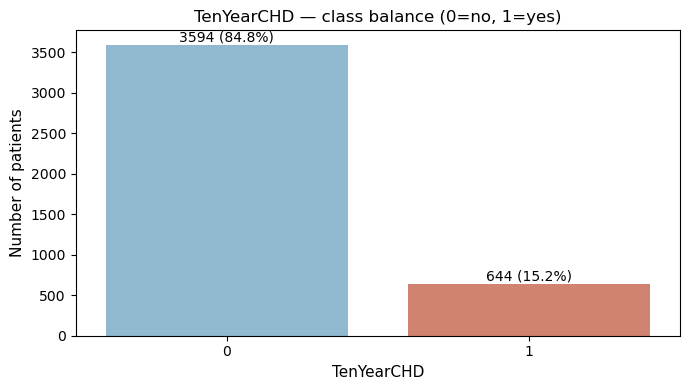

In [27]:
# Class balance (target)
plt.figure()
ax = sns.countplot(x=target_col, data=df, palette=["#86BBD8", "#E07A5F"])
ax.set_title("TenYearCHD — class balance (0=no, 1=yes)")
ax.set_xlabel("TenYearCHD")
ax.set_ylabel("Number of patients")

# annotate percentages
counts = df[target_col].value_counts().sort_index()
total = counts.sum()
for p, c in zip(ax.patches, counts):
    ax.annotate(f"{c} ({c/total:.1%})", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.savefig(plots_dir / "target_balance.png", dpi=300)
plt.show()


C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\978030814.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="muted")


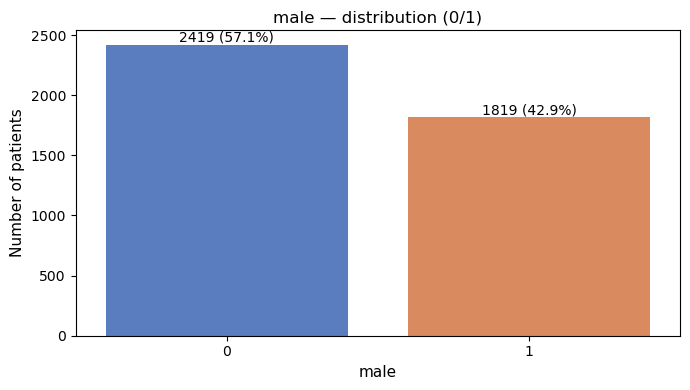

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\978030814.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="muted")


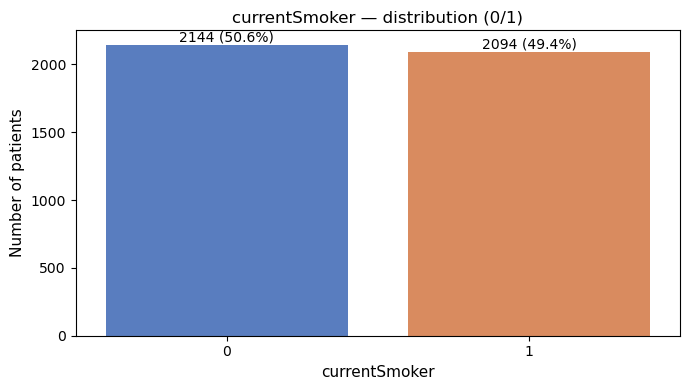

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\978030814.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="muted")


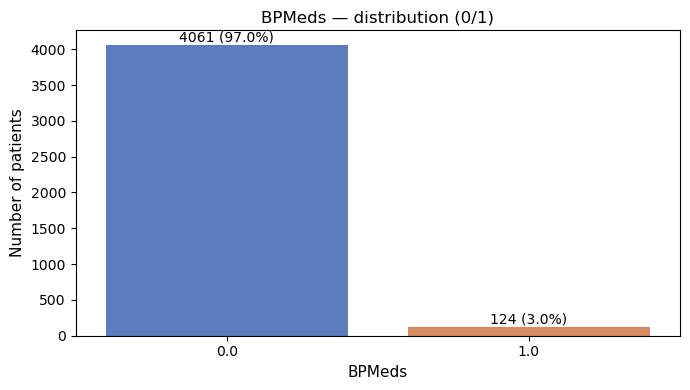

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\978030814.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="muted")


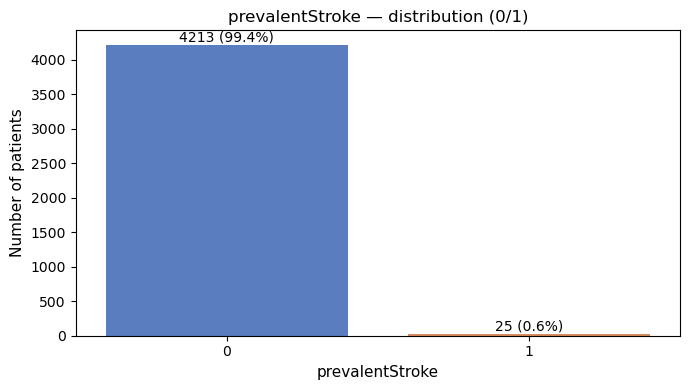

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\978030814.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="muted")


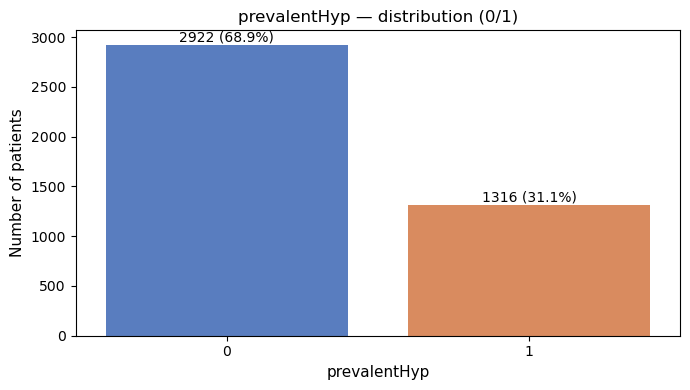

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\978030814.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="muted")


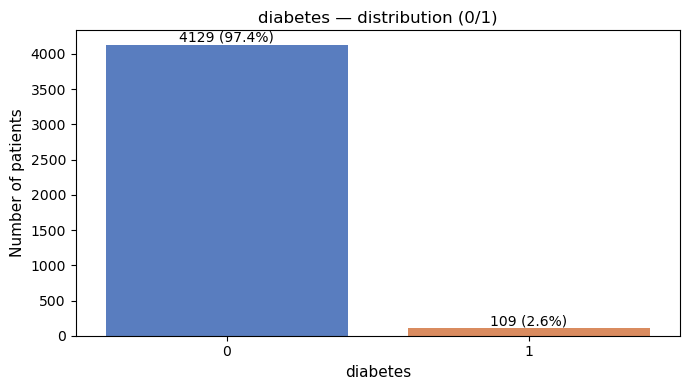

In [28]:
# Binary features (frequency counts)
for col in binary_cols:
    plt.figure()
    ax = sns.countplot(x=col, data=df, palette="muted")
    ax.set_title(f"{col} — distribution (0/1)")
    ax.set_xlabel(col)
    ax.set_ylabel("Number of patients")

    counts = df[col].value_counts().sort_index()
    total = counts.sum()
    for p, c in zip(ax.patches, counts):
        ax.annotate(f"{c} ({c/total:.1%})", (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=10)
    plt.tight_layout()
    plt.savefig(plots_dir / f"{col}_counts.png", dpi=300)
    plt.show()

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\1417446446.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=index_labels, y=counts.values, palette="muted")


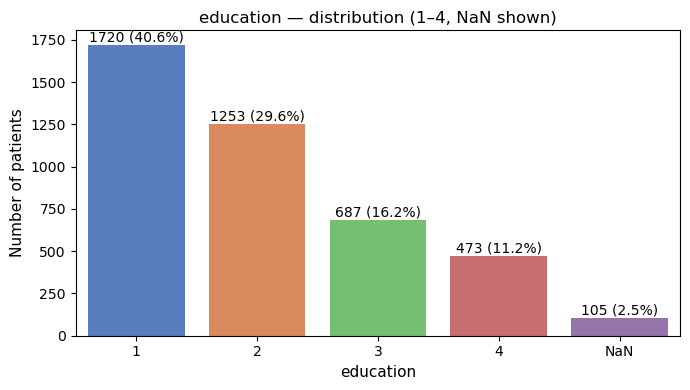

In [29]:
# Education (ordinal 1–4)
plt.figure()
counts = df["education"].value_counts(dropna=False).sort_index()
# replace NaN label
index_labels = [("NaN" if pd.isna(x) else str(int(x))) for x in counts.index]
ax = sns.barplot(x=index_labels, y=counts.values, palette="muted")
ax.set_title("education — distribution (1–4, NaN shown)")
ax.set_xlabel("education")
ax.set_ylabel("Number of patients")

total = counts.sum()
for p, c in zip(ax.patches, counts):
    ax.annotate(f"{int(c)} ({c/total:.1%})", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.savefig(plots_dir / "education_distribution.png", dpi=300)
plt.show()


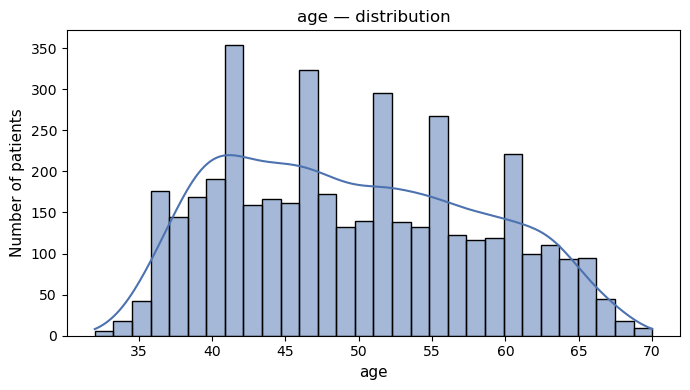

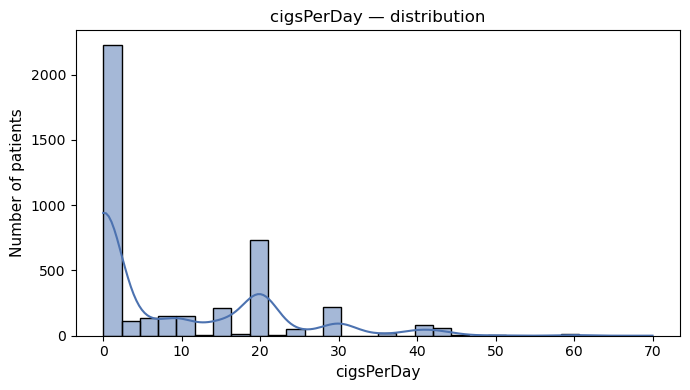

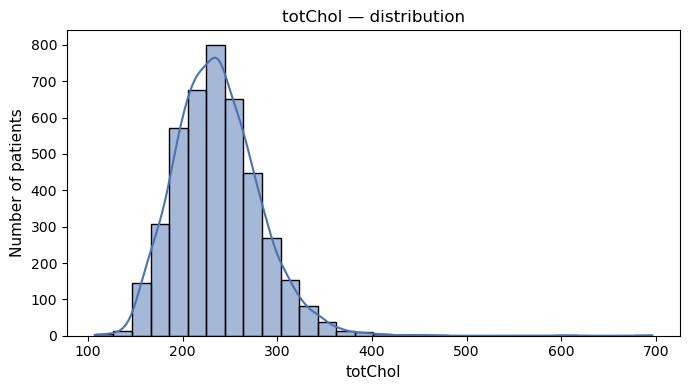

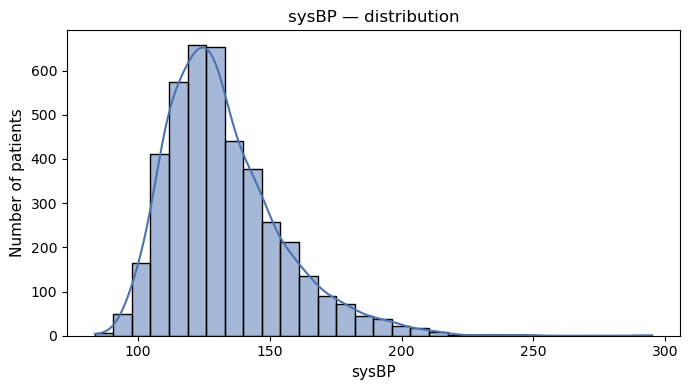

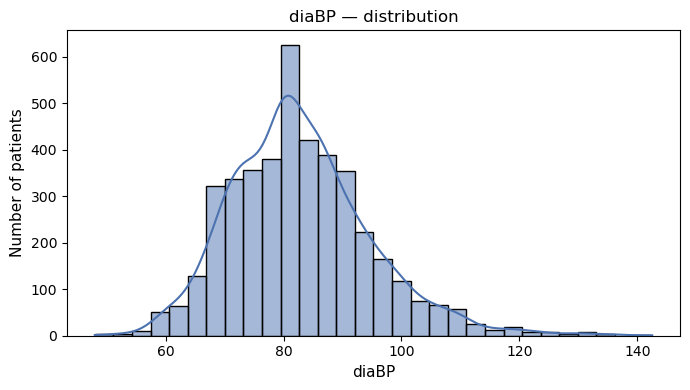

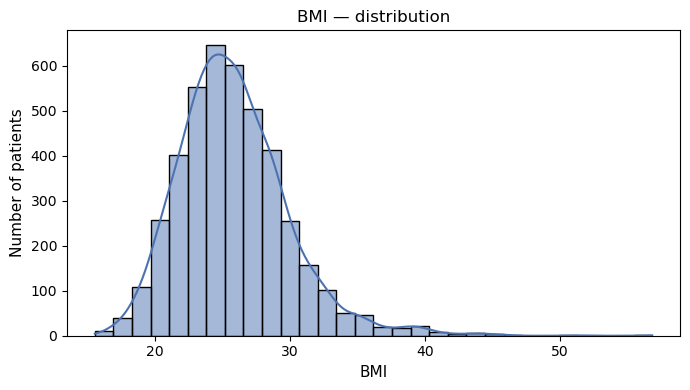

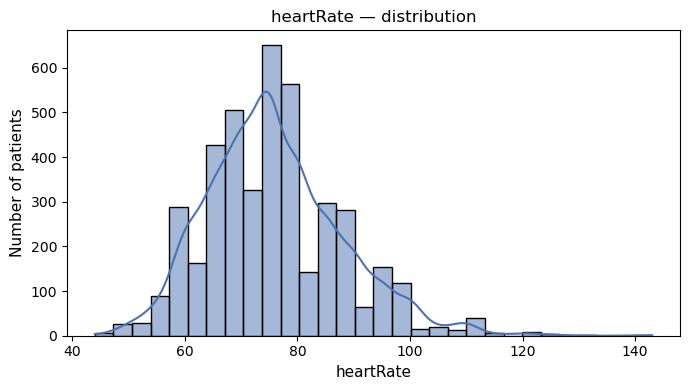

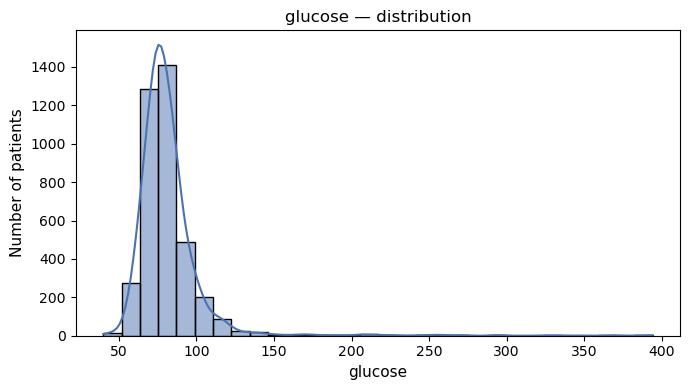

In [30]:
# Numerical features — histograms + KDE plots
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True, color="#4C72B0")
    plt.title(f"{col} — distribution")
    plt.xlabel(col)
    plt.ylabel("Number of patients")
    plt.tight_layout()
    plt.savefig(plots_dir / f"{col}_hist.png", dpi=300)
    plt.show()


C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


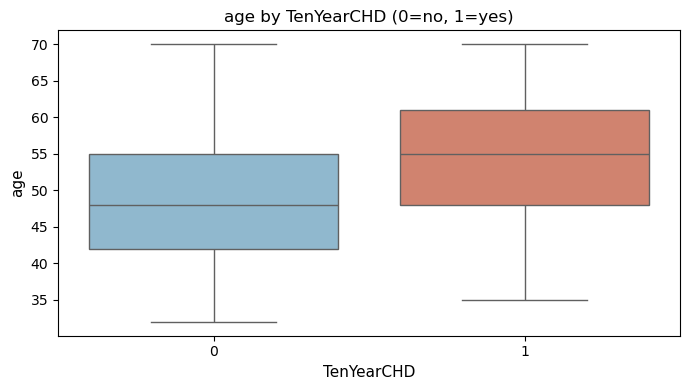

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


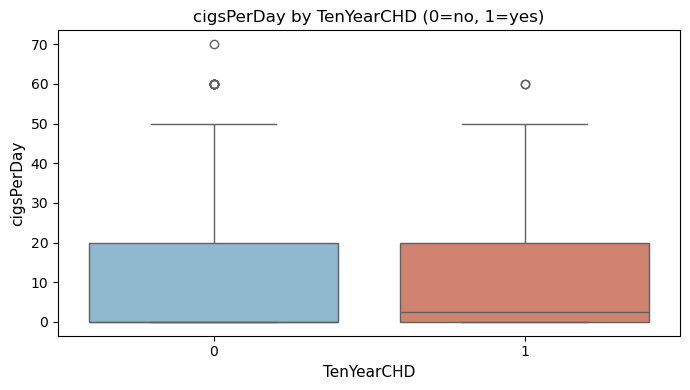

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


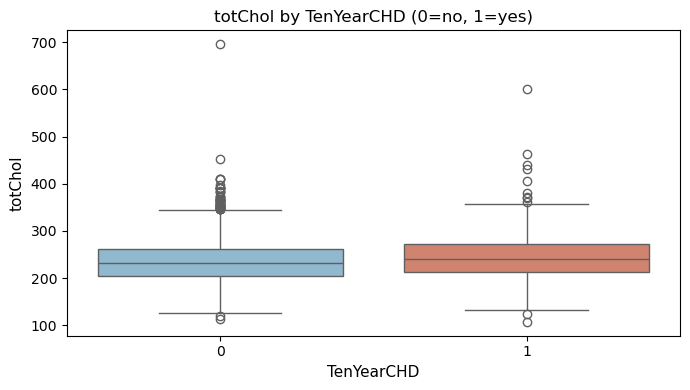

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


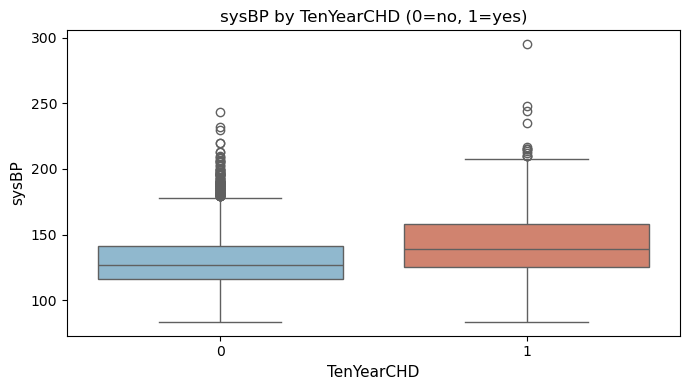

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


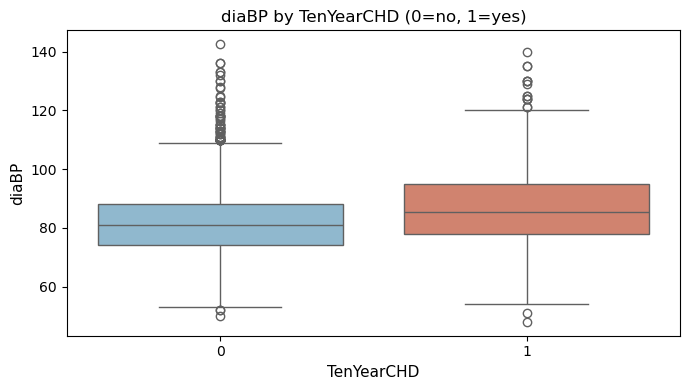

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


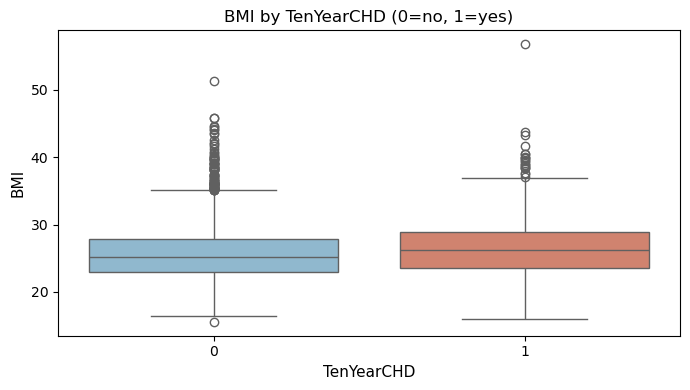

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


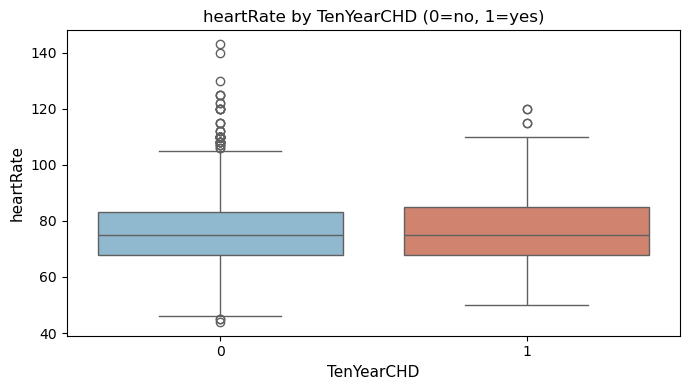

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2296621196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])


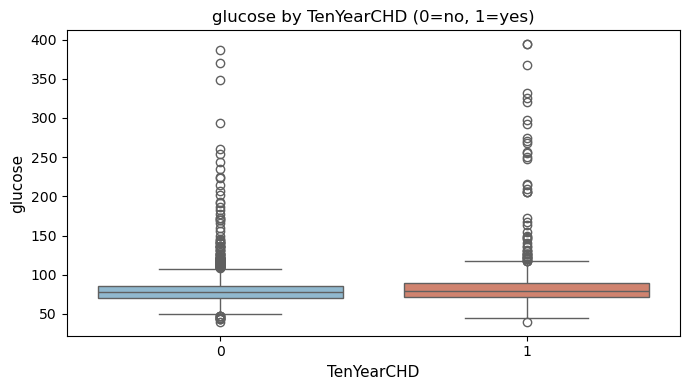

In [31]:
# Numerical vs. target — boxplots
for col in numeric_cols:
    plt.figure()
    sns.boxplot(x=target_col, y=col, data=df, palette=["#86BBD8", "#E07A5F"])
    plt.title(f"{col} by TenYearCHD (0=no, 1=yes)")
    plt.xlabel("TenYearCHD")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(plots_dir / f"{col}_by_target_box.png", dpi=300)
    plt.show()

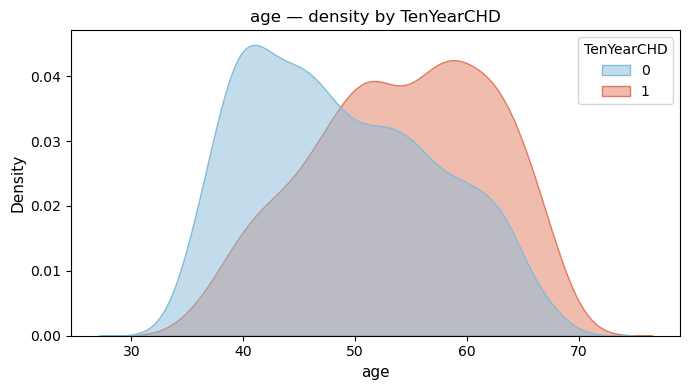

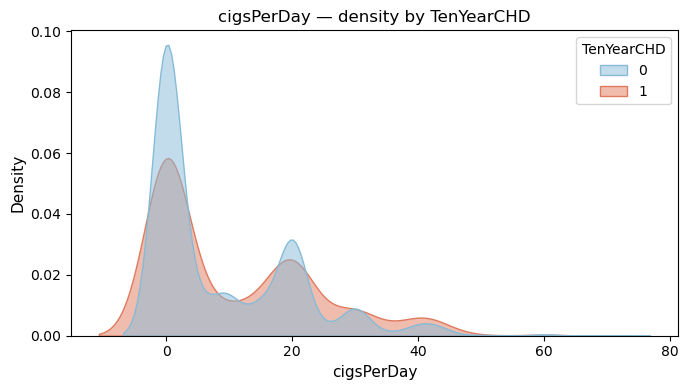

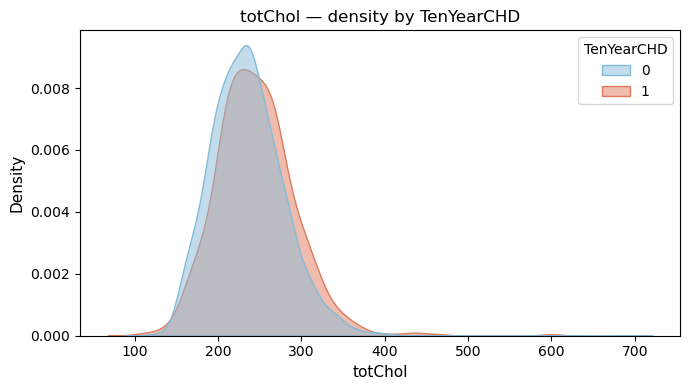

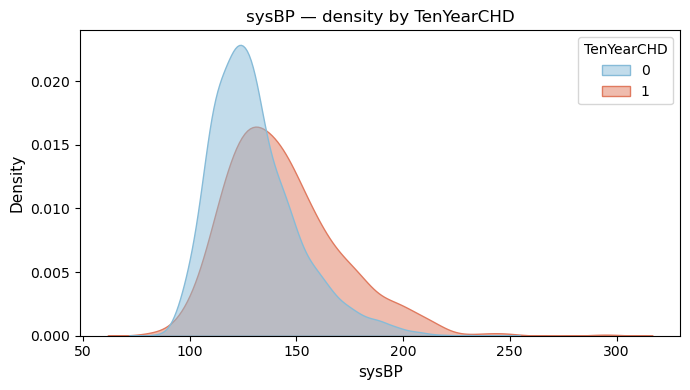

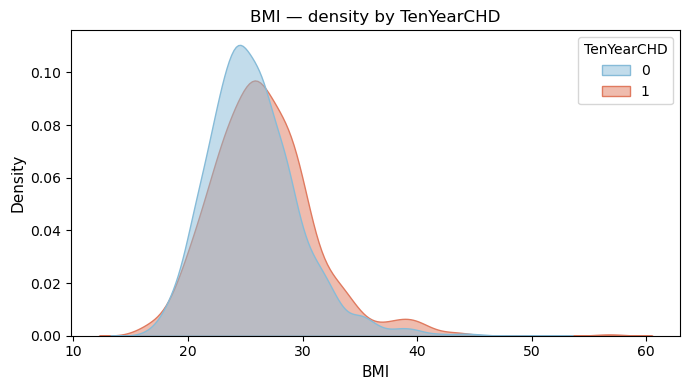

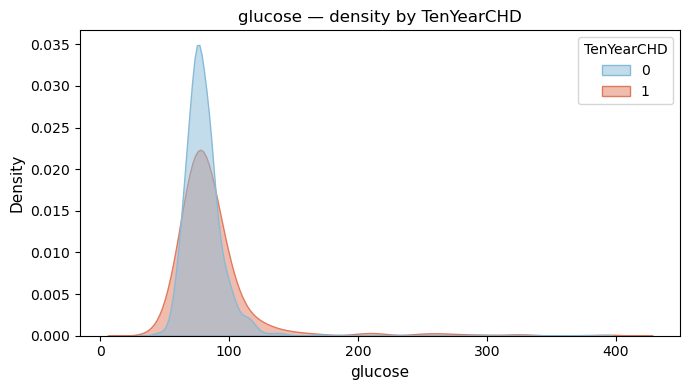

In [32]:
# Class densities (KDE curves) — key variables
kde_cols = ["age", "cigsPerDay", "totChol", "sysBP", "BMI", "glucose"]

for col in kde_cols:
    plt.figure()
    sns.kdeplot(data=df, x=col, hue=target_col, common_norm=False, fill=True,
                palette=["#86BBD8", "#E07A5F"], alpha=0.5)
    plt.title(f"{col} — density by TenYearCHD")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.savefig(plots_dir / f"{col}_kde_by_target.png", dpi=300)
    plt.show()

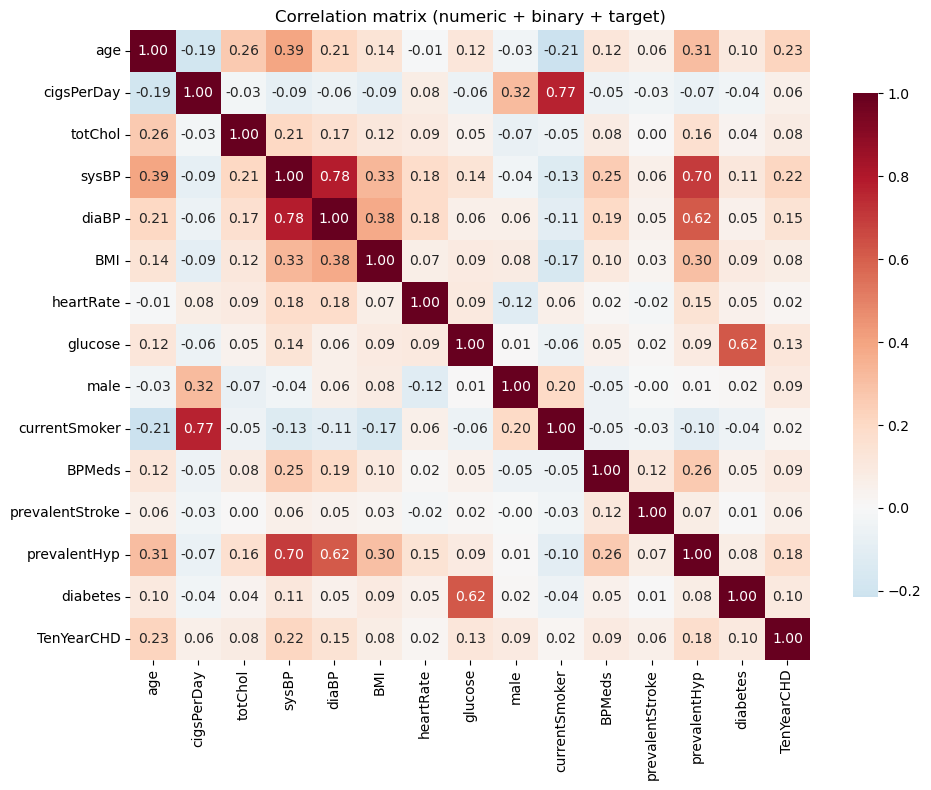

In [33]:
# Correlations (numerical + binary + target)
corr_cols = numeric_cols + binary_cols + [target_col]
corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            cbar_kws={"shrink": 0.8})
plt.title("Correlation matrix (numeric + binary + target)")
plt.tight_layout()
plt.savefig(plots_dir / "correlation_matrix.png", dpi=300)
plt.show()


## Preprocessing plan (fit on train only)

Addressing:
- **Missing values:** median (numeric) and mode (education), plus explicit missing indicators.
- **Outliers (heavy tails):** robust winsorization using train quantiles (e.g., 1st/99th percentiles).
- **Skewness:** log1p for heavily skewed positive variables (e.g., `cigsPerDay`, `glucose`, `totChol`).
- **Scaling:** robust scaling ((x - median) / IQR) computed on train.

Strict rules to prevent leakage:
- Split first (stratified).
- Fit imputers/quantiles/scalers on train only.
- Apply the same transforms to val/test using the parameters learned from train.
- Persist artifacts (imputation values, winsor limits, scaling stats, feature order).


In [34]:
# Fixed groups for Framingham dataset
TARGET_COL = "TenYearCHD"

BINARY_COLS = ["male", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]
ORDINAL_COLS = ["education"]  # 1..4 with NaNs
NUMERIC_COLS = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]

# Heavily skewed positive variables suited for log1p after winsorization
LOG1P_COLS = ["cigsPerDay", "glucose", "totChol"]


In [35]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# 70/15/15 split via two steps
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42
)  # 0.1765 of 0.85 ≈ 0.15 → 70/15/15

print("Shapes → Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)
print(
    "CHD rate → Train:", y_train.mean().round(3),
    "| Val:", y_val.mean().round(3),
    "| Test:", y_test.mean().round(3)
)

Shapes → Train: (2966, 15) | Val: (636, 15) | Test: (636, 15)
CHD rate → Train: 0.152 | Val: 0.153 | Test: 0.153


In [37]:
ARTIFACTS_DIR = Path("../artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

def fit_imputers_winsor_scaler(
    X_train: pd.DataFrame,
    binary_cols: list[str],
    ordinal_cols: list[str],
    numeric_cols: list[str],
    log1p_cols: list[str],
    q_low: float = 0.01,
    q_high: float = 0.99,
) -> dict:
    """Fitting robust preprocessing on train: imputation, winsorization, log1p plan, and robust scaling stats.

    Returns
    -------
    dict
        Serializable preprocessing parameters:
        - impute_median: {col: value}
        - impute_mode_education: value
        - impute_binary_defaults: {binary_col: 0}
        - winsor_limits: {col: (low_q, high_q)}
        - log1p_cols: list
        - robust_center: {col: median_after_winsor_and_log}
        - robust_scale: {col: IQR_after_winsor_and_log}
        - feature_order: final ordered list of columns (including missing indicators)
    """
    params: dict = {}

    # 1) Imputation values
    # Calculates the median (different from the mean) by sorting the numbers,
    # taking the middle values, summing them, and dividing by 2.
    # The mean is sensitive to extreme values, while the median better represents
    # the center of a skewed distribution or one with outliers.
    impute_median = {c: float(X_train[c].median()) for c in numeric_cols}
    # For ordered categorical columns (e.g., education level 1–4),
    # use the most frequent value (the mode).
    # If multiple modes, pandas picks the smallest.
    impute_mode_education = float(X_train["education"].mode(dropna=True)[0])
    # binary NaNs default to 0 (plus explicit missing indicators later if needed)
    impute_binary_defaults = {c: 0.0 for c in binary_cols}

    # 2) Winsorization (trim extreme values): cap values at chosen lower/upper
    # Calculate the 1st and 99th percentile limits for each numeric column.
    # If a value falls outside this range, cap it to protect the model.
    # Example: if most heart rates are between 40 and 180 but one is 900 → cap at 180.
    # This prevents extreme “crazy” values from distorting the learning process.
    winsor_limits = {
        c: (float(X_train[c].quantile(q_low)), float(X_train[c].quantile(q_high)))
        for c in numeric_cols
    }

    # 3) Robust scaling on transformed train (median/IQR after winsor + log1p where applicable)
    X_tmp = X_train.copy()

    # Impute preliminarily to compute robust stats consistently
    for c in numeric_cols:
        X_tmp[c] = X_tmp[c].fillna(impute_median[c])
    X_tmp["education"] = X_tmp["education"].fillna(impute_mode_education)
    for c in binary_cols:
        X_tmp[c] = X_tmp[c].fillna(impute_binary_defaults[c])

    # Winsorize
    for c in numeric_cols:
        lo, hi = winsor_limits[c]
        X_tmp[c] = X_tmp[c].clip(lower=lo, upper=hi)

    # Log1p where defined (ensure non-negative before log1p)
    for c in log1p_cols:
        X_tmp[c] = np.log1p(np.clip(X_tmp[c], a_min=0, a_max=None))

    # Robust center/scale
    # Now compute medians AFTER:
    # 1) imputing, 2) winsorizing (trimming extremes), and 3) applying log1p (if applicable).
    # We need the center of the already-transformed data to scale correctly.
    # If you change the data’s shape, its “normal” (median) changes too—recalculate it now for proper scaling.

    robust_center = {c: float(X_tmp[c].median()) for c in numeric_cols}
    robust_scale = {}
    for c in numeric_cols:
        q75 = float(X_tmp[c].quantile(0.75))
        q25 = float(X_tmp[c].quantile(0.25))
        iqr = max(q75 - q25, 1e-6)  # avoid division by zero
        robust_scale[c] = float(iqr)

    # 4) Feature order (numeric transformed + binary + ordinal + missing indicators)
    # If a column had any NaNs in training, create a new indicator column: col_is_missing (0/1).
    # Why? Missingness itself can be informative and help the model.
    missing_indicator_cols = []
    train_na = X_train.isna().sum()
    for c in numeric_cols + ordinal_cols + binary_cols:
        if train_na[c] > 0:
            missing_indicator_cols.append(f"{c}_is_missing")

    feature_order = (
        [f"{c}_scaled" for c in numeric_cols]  # scaled numeric
        + binary_cols
        + ordinal_cols
        + missing_indicator_cols
    )

    params["impute_median"] = impute_median
    params["impute_mode_education"] = impute_mode_education
    params["impute_binary_defaults"] = impute_binary_defaults
    params["winsor_limits"] = winsor_limits
    params["log1p_cols"] = log1p_cols
    params["robust_center"] = robust_center
    params["robust_scale"] = robust_scale
    params["feature_order"] = feature_order
    params["missing_indicator_cols"] = missing_indicator_cols
    return params


preproc_params = fit_imputers_winsor_scaler(
    X_train, BINARY_COLS, ORDINAL_COLS, NUMERIC_COLS, LOG1P_COLS,
)

# Persist preprocessing params (JSON-friendly)
with open(ARTIFACTS_DIR / "preprocessing_params.json", "w") as f:
    json.dump(preproc_params, f, indent=2)

print("Saved:", (ARTIFACTS_DIR / "preprocessing_params.json").resolve())
print("Feature order length:", len(preproc_params["feature_order"]))


Saved: C:\Users\Zakaria\Downloads\heart-disease-prediction\artifacts\preprocessing_params.json
Feature order length: 22


In [38]:
def transform_dataframe(
    X: pd.DataFrame,
    params: dict,
    binary_cols: list[str],
    ordinal_cols: list[str],
    numeric_cols: list[str],
) -> pd.DataFrame:
    """Applying train-fitted preprocessing to a DataFrame.

    Steps
    -----
    1) Impute numeric (median), education (mode), binary (0).
    2) Winsorize numeric using train quantiles.
    3) Log1p for selected numeric columns.
    4) Robust scale numeric: (x - median) / IQR (based on train stats).
    5) Add missing indicators for columns that had NaNs in train.
    6) Return DataFrame with columns in 'feature_order'.
    """
    X_t = X.copy()

    # 1) Impute
    for c, med in params["impute_median"].items():
        X_t[c] = X_t[c].fillna(med)
    X_t["education"] = X_t["education"].fillna(params["impute_mode_education"])
    for c, default in params["impute_binary_defaults"].items():
        X_t[c] = X_t[c].fillna(default)

    # Build missing indicators (based on train columns that had NaNs)
    for mcol in params["missing_indicator_cols"]:
        orig = mcol.replace("_is_missing", "")
        X_t[mcol] = X[orig].isna().astype(float)

    # 2) Winsorization
    for c in numeric_cols:
        lo, hi = params["winsor_limits"][c]
        X_t[c] = X_t[c].clip(lower=lo, upper=hi)

    # 3) Log1p
    for c in params["log1p_cols"]:
        X_t[c] = np.log1p(np.clip(X_t[c], a_min=0, a_max=None))

    # 4) Robust scaling
    for c in numeric_cols:
        med = params["robust_center"][c]
        iqr = params["robust_scale"][c]
        X_t[f"{c}_scaled"] = (X_t[c] - med) / iqr

    # 5) Final assembly in the exact feature order
    feature_order = params["feature_order"]
    X_out = pd.DataFrame(index=X_t.index)
    for col in feature_order:
        if col in X_t.columns:
            X_out[col] = X_t[col]
        else:
            # columns that might not exist (e.g., missing indicators in other splits)
            X_out[col] = 0.0

    # Cast binary/ordinal to float for PyTorch tensors
    for c in BINARY_COLS + ORDINAL_COLS:
        if c in X_out:
            X_out[c] = X_out[c].astype(float)

    return X_out

In [39]:
# Apply preprocessing
X_train_proc = transform_dataframe(X_train, preproc_params, BINARY_COLS, ORDINAL_COLS, NUMERIC_COLS)
X_val_proc   = transform_dataframe(X_val,   preproc_params, BINARY_COLS, ORDINAL_COLS, NUMERIC_COLS)
X_test_proc  = transform_dataframe(X_test,  preproc_params, BINARY_COLS, ORDINAL_COLS, NUMERIC_COLS)

print("Processed shapes →", X_train_proc.shape, X_val_proc.shape, X_test_proc.shape)
print("First columns:", list(X_train_proc.columns[:8]))

# Persist processed splits for reproducibility/debugging (optional)
X_train_proc.to_parquet(ARTIFACTS_DIR / "X_train_proc.parquet", index=False)
X_val_proc.to_parquet(ARTIFACTS_DIR / "X_val_proc.parquet", index=False)
X_test_proc.to_parquet(ARTIFACTS_DIR / "X_test_proc.parquet", index=False)

y_train.to_frame("y").to_parquet(ARTIFACTS_DIR / "y_train.parquet", index=False)
y_val.to_frame("y").to_parquet(ARTIFACTS_DIR / "y_val.parquet", index=False)
y_test.to_frame("y").to_parquet(ARTIFACTS_DIR / "y_test.parquet", index=False)

print("Saved processed datasets to:", ARTIFACTS_DIR.resolve())


Processed shapes → (2966, 22) (636, 22) (636, 22)
First columns: ['age_scaled', 'cigsPerDay_scaled', 'totChol_scaled', 'sysBP_scaled', 'diaBP_scaled', 'BMI_scaled', 'heartRate_scaled', 'glucose_scaled']
Saved processed datasets to: C:\Users\Zakaria\Downloads\heart-disease-prediction\artifacts


# Post-processing sanity checks (distributions & scaling)

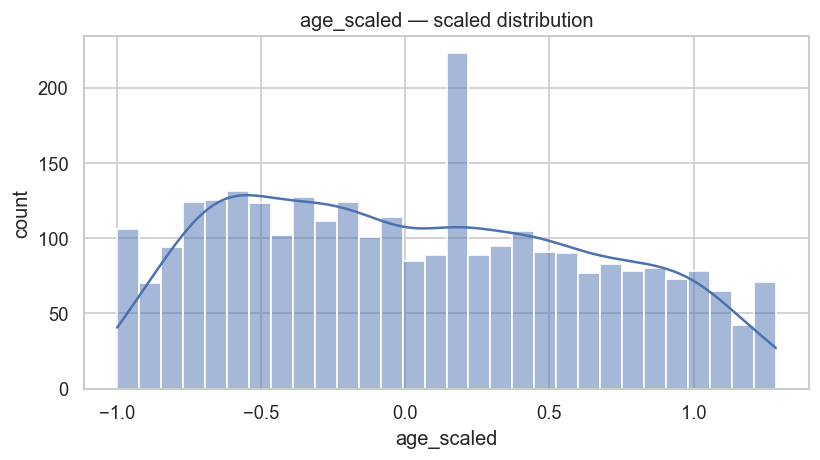

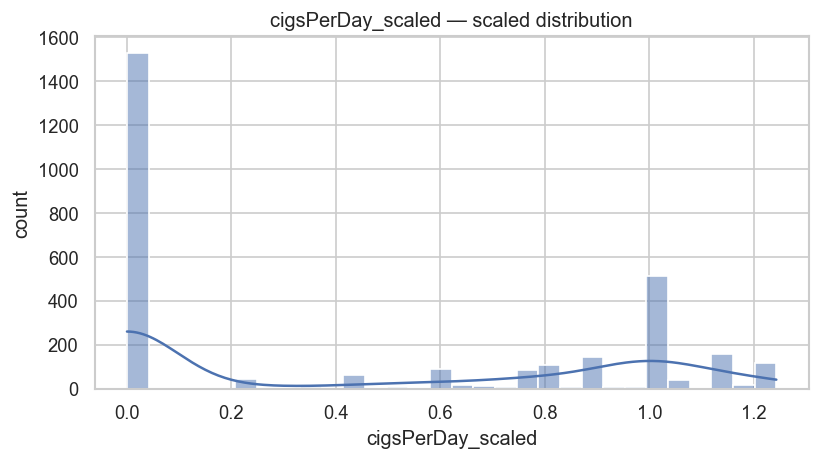

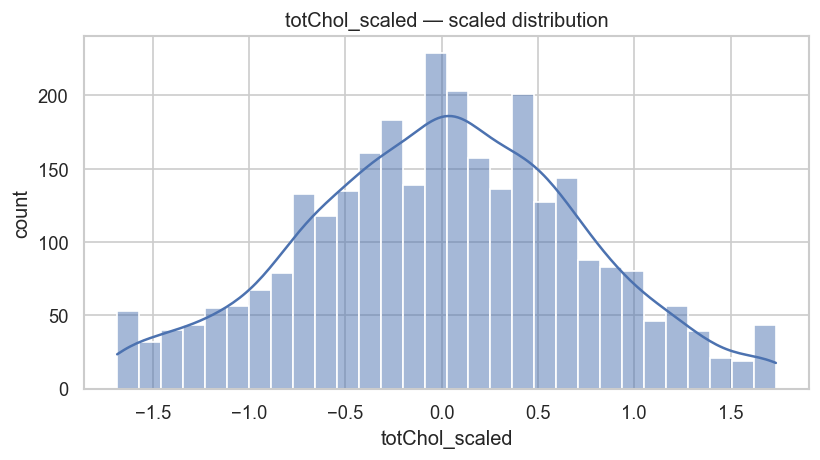

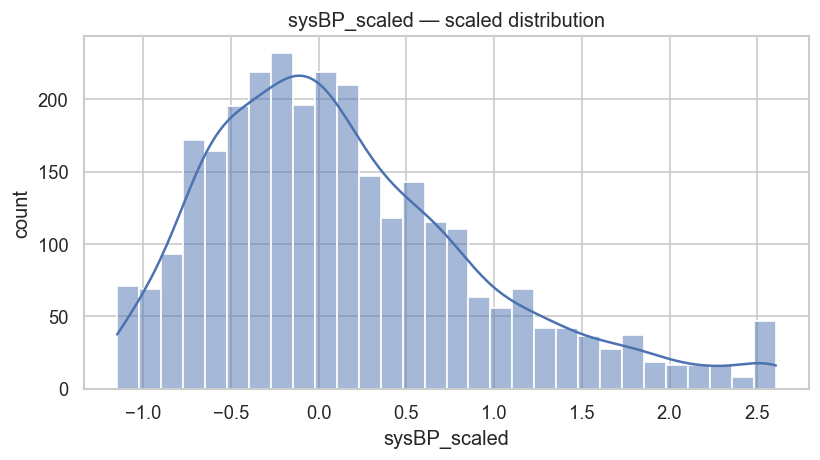

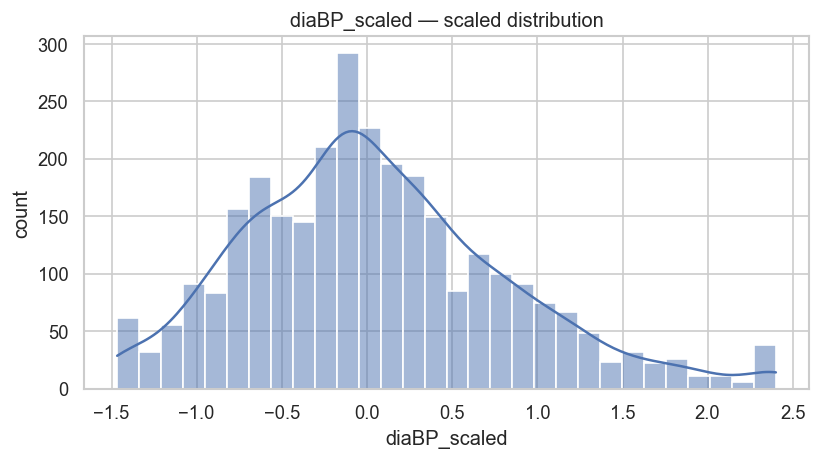

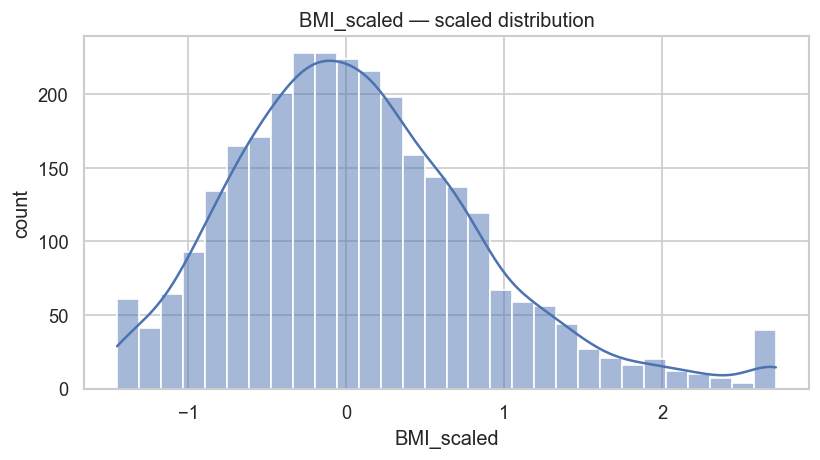

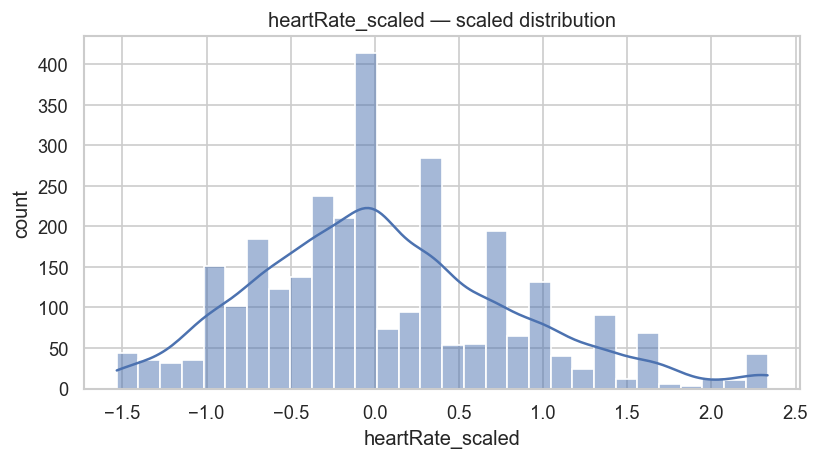

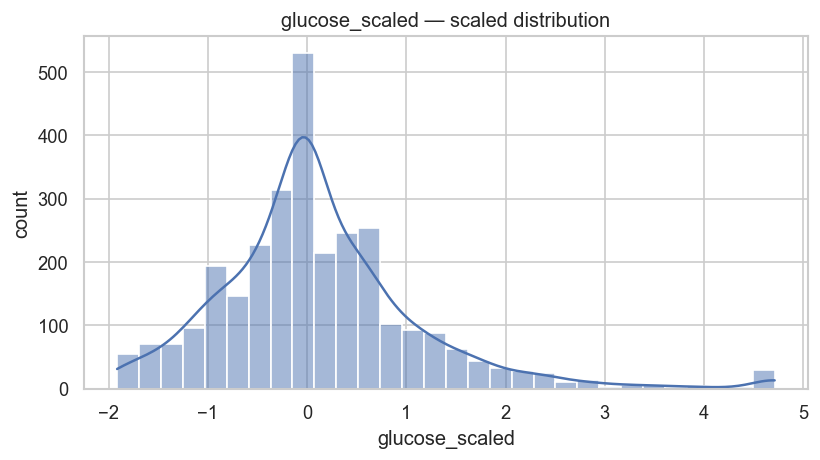

,feature,median_after_scale,IQR_after_scale
0,age_scaled,0.0,1.0
1,cigsPerDay_scaled,0.0,1.0
2,totChol_scaled,0.0,1.0
3,sysBP_scaled,0.0,1.0
4,diaBP_scaled,0.0,1.0
5,BMI_scaled,0.0,1.0
6,heartRate_scaled,0.0,1.0
7,glucose_scaled,0.0,1.0


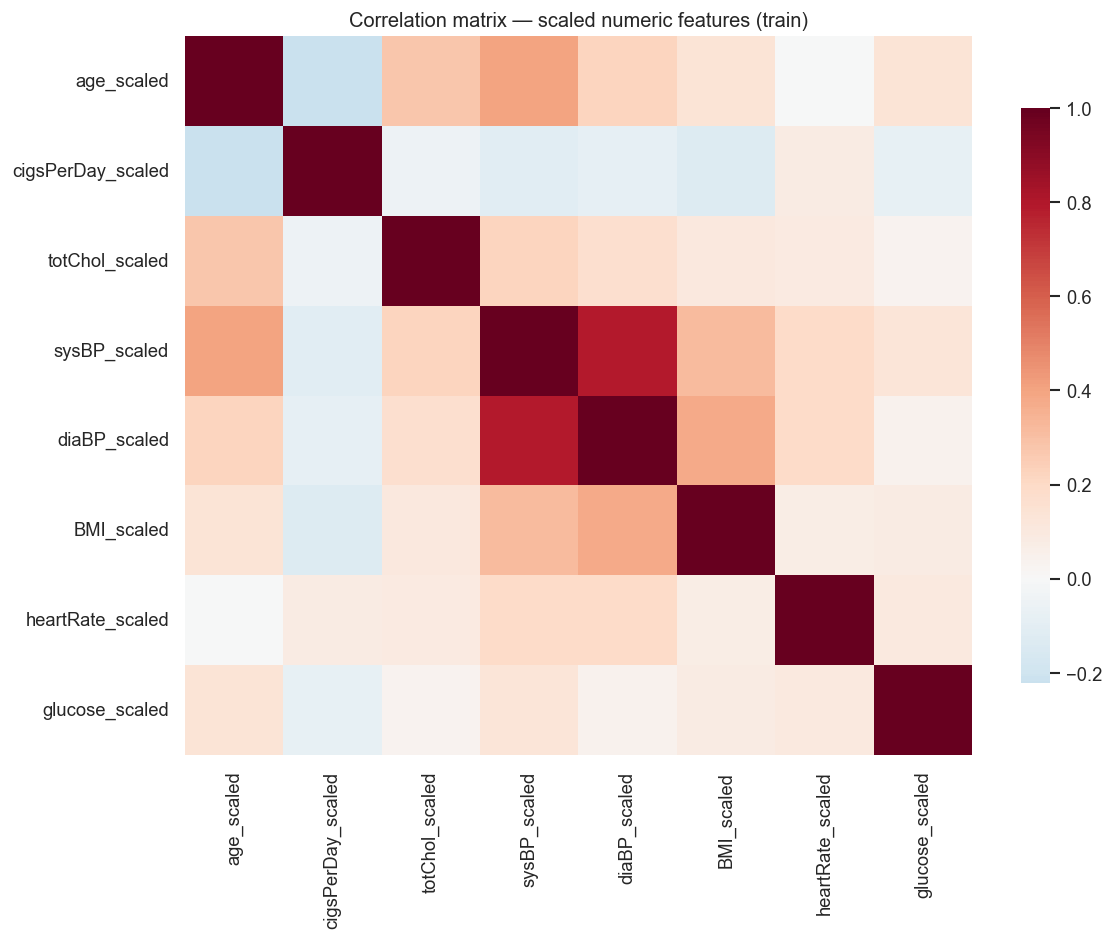

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


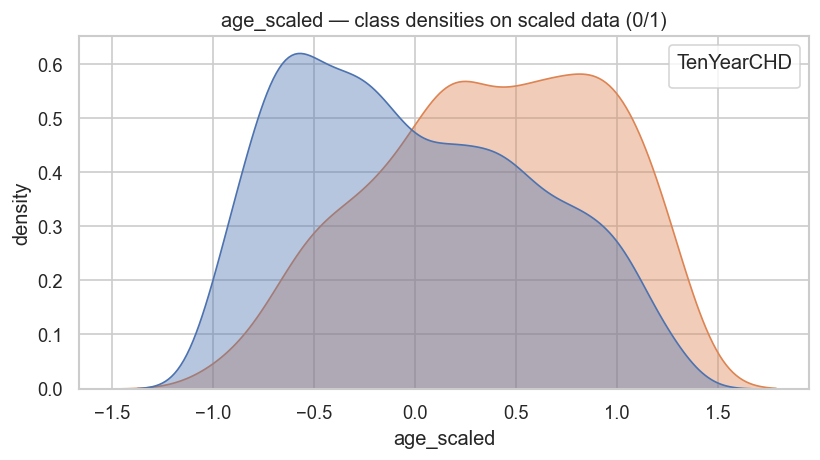

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


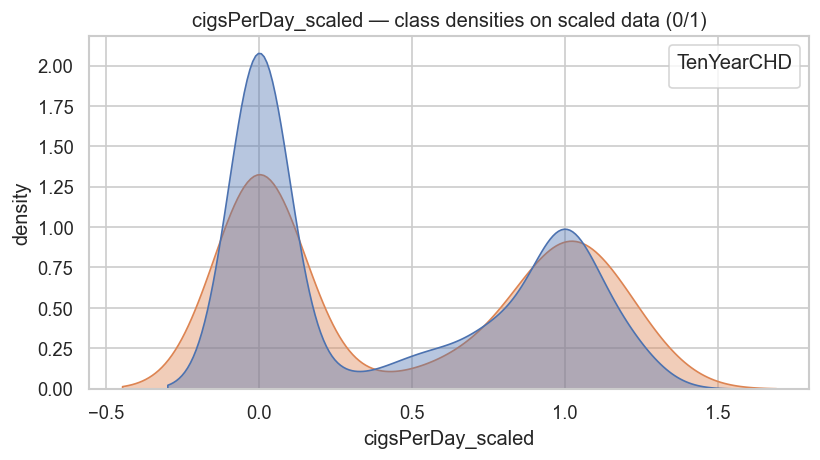

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


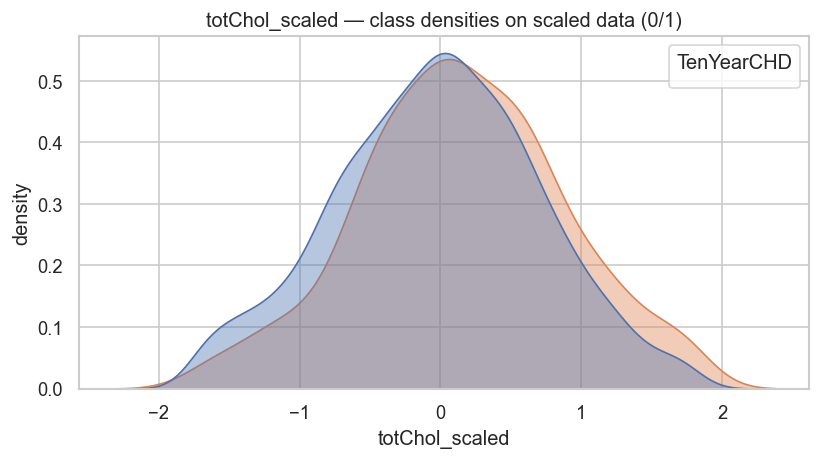

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


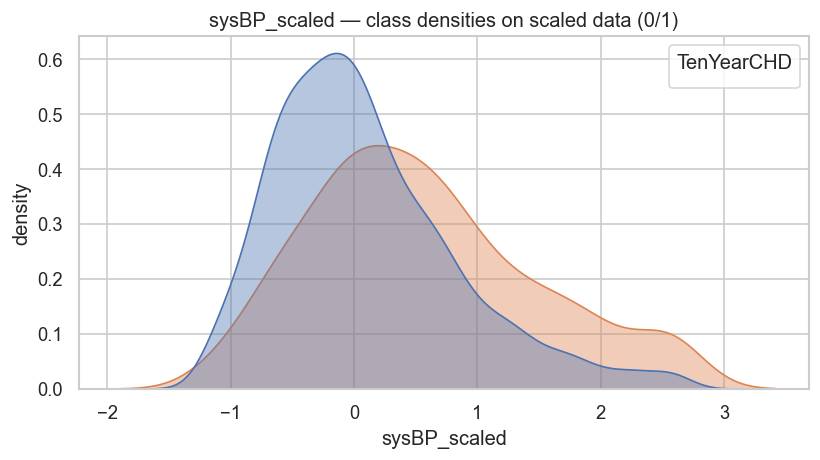

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


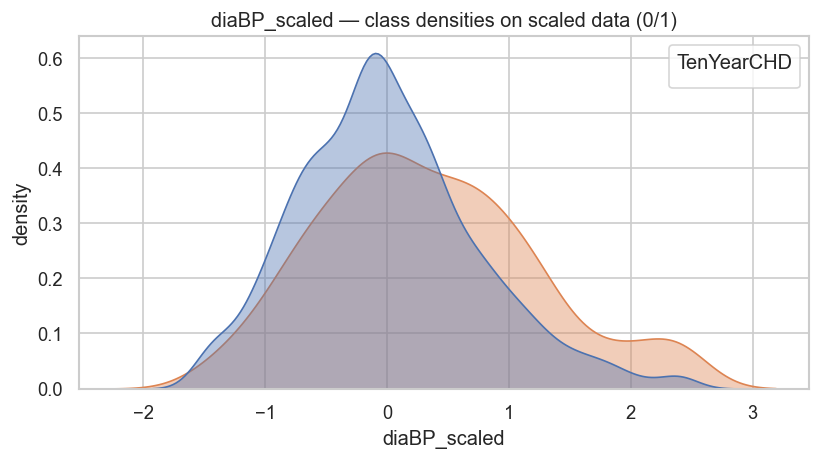

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


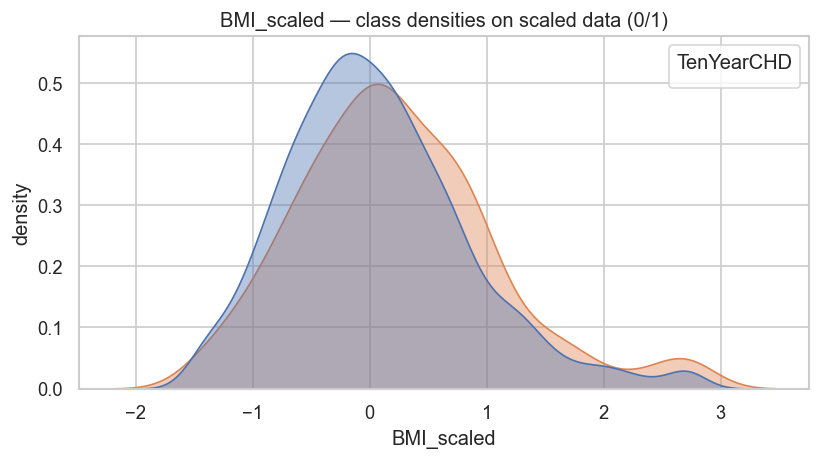

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


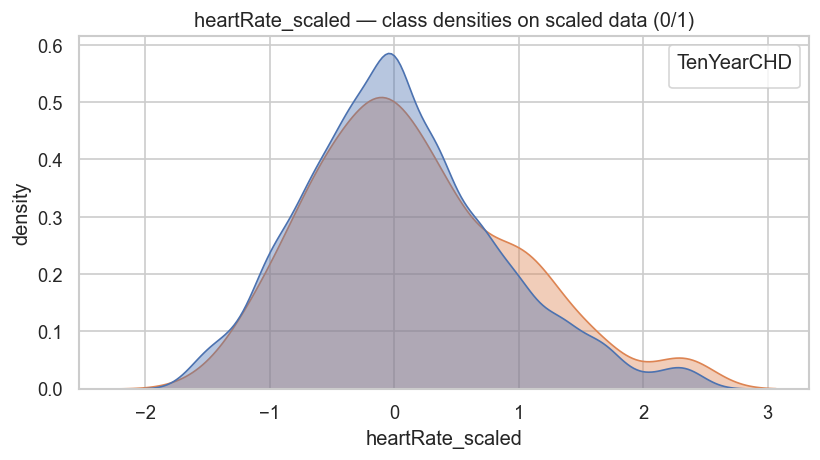

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_24336\2783833356.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="TenYearCHD")


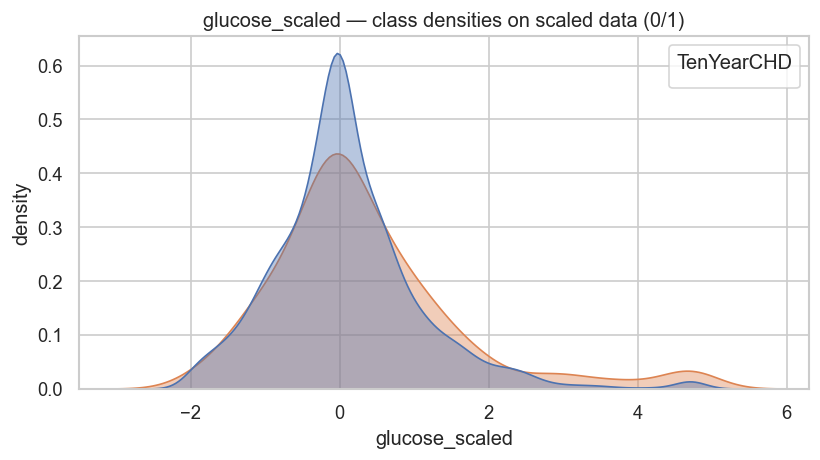

Saved scaled-only plots to: C:\Users\Zakaria\Downloads\heart-disease-prediction\artifacts\plots_scaled_only


In [51]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["figure.dpi"] = 120

# using a folder to store the figures
scaled_plots_dir = Path("../artifacts/plots_scaled_only")
scaled_plots_dir.mkdir(parents=True, exist_ok=True)

# using the list of scaled numeric columns
scaled_cols = [f"{c}_scaled" for c in NUMERIC_COLS if f"{c}_scaled" in X_train_proc.columns]

# 1) Histograms + KDE for scaled numeric features (train only)
for sc in scaled_cols:
    fig, ax = plt.subplots()
    sns.histplot(X_train_proc[sc], bins=30, kde=True, ax=ax)
    ax.set_title(f"{sc} — scaled distribution")
    ax.set_xlabel(sc)
    ax.set_ylabel("count")
    plt.tight_layout()
    plt.savefig(scaled_plots_dir / f"{sc}_hist_scaled.png", dpi=300)
    plt.show()

# 2) Quick scaling sanity table: median ≈ 0, IQR ≈ 1 (train only)
def iqr(s: pd.Series) -> float:
    return float(s.quantile(0.75) - s.quantile(0.25))

rows = []
for sc in scaled_cols:
    rows.append({
        "feature": sc,
        "median_after_scale": round(float(X_train_proc[sc].median()), 3),
        "IQR_after_scale": round(iqr(X_train_proc[sc]), 3),
    })
scaled_check = pd.DataFrame(rows)
display(scaled_check)

# 3) Correlation heatmap on scaled numeric features (train only)
if len(scaled_cols) >= 2:
    corr_scaled = X_train_proc[scaled_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_scaled, annot=False, cmap="RdBu_r", center=0, cbar_kws={"shrink": 0.8})
    plt.title("Correlation matrix — scaled numeric features (train)")
    plt.tight_layout()
    plt.savefig(scaled_plots_dir / "correlation_scaled.png", dpi=300)
    plt.show()

# 4) Class-conditioned KDE on scaled features (train only)
# using y_train to visualize per-class densities without touching raw data
for sc in scaled_cols:
    fig, ax = plt.subplots()
    sns.kdeplot(x=X_train_proc[sc], hue=y_train, common_norm=False, fill=True, alpha=0.4, ax=ax)
    ax.set_title(f"{sc} — class densities on scaled data (0/1)")
    ax.set_xlabel(sc)
    ax.set_ylabel("density")
    ax.legend(title="TenYearCHD")
    plt.tight_layout()
    plt.savefig(scaled_plots_dir / f"{sc}_kde_scaled_by_class.png", dpi=300)
    plt.show()

print("Saved scaled-only plots to:", scaled_plots_dir.resolve())

In [41]:
# Compute pos_weight on TRAIN ONLY for BCEWithLogitsLoss
n_pos = int(y_train.sum())
n_neg = int((y_train == 0).sum())
pos_weight = n_neg / max(n_pos, 1)
print(f"Train class counts → neg={n_neg}, pos={n_pos} | pos_weight={pos_weight:.3f}")

# Save basic config for training
train_config = {
    "seed": 42,
    "pos_weight": float(pos_weight),
    "feature_order": preproc_params["feature_order"],
    "log1p_cols": preproc_params["log1p_cols"],
}
with open(ARTIFACTS_DIR / "config.json", "w") as f:
    json.dump(train_config, f, indent=2)

print("Saved:", (ARTIFACTS_DIR / "config.json").resolve())


Train class counts → neg=2516, pos=450 | pos_weight=5.591
Saved: C:\Users\Zakaria\Downloads\heart-disease-prediction\artifacts\config.json


## Building PyTorch datasets

Converting processed pandas DataFrames into tensors and creating DataLoaders.

Design choices
- Keep float32 tensors for features and targets.
- Do not apply sigmoid inside the model (use BCEWithLogitsLoss).
- Shuffle only the training loader.

In [46]:
# Ensure we have the processed splits in memory; if not, load them from artifacts.
# X_train_proc, X_val_proc, X_test_proc, y_train, y_val, y_test should already exist.
# If the kernel got restarted, uncomment this lines:
# import pandas as pd
# from pathlib import Path
# ARTIFACTS_DIR = Path("../artifacts")
# X_train_proc = pd.read_parquet(ARTIFACTS_DIR / "X_train_proc.parquet")
# X_val_proc   = pd.read_parquet(ARTIFACTS_DIR / "X_val_proc.parquet")
# X_test_proc  = pd.read_parquet(ARTIFACTS_DIR / "X_test_proc.parquet")
# y_train = pd.read_parquet(ARTIFACTS_DIR / "y_train.parquet")["y"]
# y_val   = pd.read_parquet(ARTIFACTS_DIR / "y_val.parquet")["y"]
# y_test  = pd.read_parquet(ARTIFACTS_DIR / "y_test.parquet")["y"]

class FrameDataset(Dataset):
    """Thin wrapper converting pandas DataFrame/Series into a PyTorch Dataset.

    Parameters
    ----------
    X_df : pd.DataFrame
        Preprocessed features with a fixed, known column order.
    y_ser : pd.Series | np.ndarray | None
        Target labels (0/1). Use None for test-time inference.
    """

    def __init__(self, X_df: pd.DataFrame, y_ser=None) -> None:
        self.X = torch.tensor(X_df.values, dtype=torch.float32)
        self.y = None if y_ser is None else torch.tensor(np.asarray(y_ser), dtype=torch.float32)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]


BATCH_SIZE = 256

train_ds = FrameDataset(X_train_proc, y_train)
val_ds   = FrameDataset(X_val_proc,   y_val)
test_ds  = FrameDataset(X_test_proc,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

in_features = X_train_proc.shape[1]
in_features

22

## Logistic Regression model

Using a single linear layer that outputs logits (no sigmoid in `forward`).
Loss: `BCEWithLogitsLoss` with `pos_weight` to address class imbalance.

In [ ]:

class LogisticRegressionTorch(nn.Module):
    """Logistic regression implemented as a single Linear layer.

    Notes
    -----
    - The forward returns raw logits.
    - Apply sigmoid outside when converting to probabilities.
    """

    def __init__(self, in_features: int) -> None:
        super().__init__()
        self.linear = nn.Linear(in_features, 1, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x).squeeze(1)  # shape: (batch,)

## Training utilities

- Loss: BCEWithLogitsLoss(pos_weight)
- Optimizer: Adam with weight decay (L2)
- Metrics on validation: ROC-AUC, PR-AUC, Accuracy at 0.5
- We will later select a decision threshold on the validation set to maximize F1.

In [52]:
def evaluate_logits(y_true: np.ndarray, logits: np.ndarray) -> dict:
    """Compute standard metrics from logits (before threshold tuning)."""
    probs = 1 / (1 + np.exp(-logits))
    metrics = {}
    # Guarded computations for edge cases
    try:
        metrics["roc_auc"] = float(roc_auc_score(y_true, probs))
    except ValueError:
        metrics["roc_auc"] = float("nan")
    try:
        metrics["pr_auc"] = float(average_precision_score(y_true, probs))
    except ValueError:
        metrics["pr_auc"] = float("nan")

    # Default accuracy at 0.5 for reference
    preds05 = (probs >= 0.5).astype(int)
    metrics["acc@0.5"] = float(accuracy_score(y_true, preds05))
    return metrics


def run_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer=None, device: torch.device = torch.device("cpu")) -> tuple[float, np.ndarray, np.ndarray]:
    """Run one epoch for training or evaluation.

    Parameters
    ----------
    model : nn.Module
    loader : DataLoader
    criterion : loss function (BCEWithLogitsLoss)
    optimizer : torch.optim.Optimizer | None
        If provided, performs training, otherwise evaluation-only.
    device : torch.device

    Returns
    -------
    avg_loss : float
    y_true : np.ndarray
    logits : np.ndarray
    """
    model.to(device)
    is_train = optimizer is not None
    model.train(is_train)

    losses = []
    all_logits = []
    all_targets = []

    for batch in loader:
        if is_train:
            Xb, yb = batch
        else:
            Xb, yb = batch

        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        all_logits.append(logits.detach().cpu().numpy())
        all_targets.append(yb.detach().cpu().numpy())

    avg_loss = float(np.mean(losses))
    y_true = np.concatenate(all_targets)
    logits = np.concatenate(all_logits)
    return avg_loss, y_true, logits


## Training (with class-imbalance handling)

- `pos_weight = #neg / #pos` computed on **train only**.
- Track train/val loss and val ROC-AUC/PR-AUC.
- Save the best model by **val PR-AUC** (more informative with imbalance).

In [53]:
# pos_weight computed previously on TRAIN ONLY
# If you reloaded the notebook and don't have it:
# n_pos = int(y_train.sum()); n_neg = int((y_train == 0).sum()); pos_weight = n_neg / max(n_pos, 1)

model = LogisticRegressionTorch(in_features=in_features)

pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32, device=DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS = 50
PATIENCE = 8  # early stopping on val PR-AUC

best_state = None
best_val_prauc = -np.inf
epochs_no_improve = 0
history = []

model.to(DEVICE)

for epoch in range(1, EPOCHS + 1):
    train_loss, ytr, logtr = run_epoch(model, train_loader, criterion, optimizer=optimizer, device=DEVICE)
    val_loss, yva, lova   = run_epoch(model, val_loader,   criterion, optimizer=None,   device=DEVICE)

    val_metrics = evaluate_logits(yva, lova)
    train_metrics = evaluate_logits(ytr, logtr)

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_roc_auc": train_metrics["roc_auc"],
        "val_roc_auc": val_metrics["roc_auc"],
        "train_pr_auc": train_metrics["pr_auc"],
        "val_pr_auc": val_metrics["pr_auc"],
        "val_acc@0.5": val_metrics["acc@0.5"],
    })

    print(f"[{epoch:02d}] "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"val ROC-AUC={val_metrics['roc_auc']:.3f} PR-AUC={val_metrics['pr_auc']:.3f} acc@0.5={val_metrics['acc@0.5']:.3f}")

    # Early stopping based on PR-AUC
    if val_metrics["pr_auc"] > best_val_prauc:
        best_val_prauc = val_metrics["pr_auc"]
        best_state = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "val_metrics": val_metrics,
        }
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no improvement in val PR-AUC for {PATIENCE} epochs).")
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state["model_state"])
    print("Loaded best model (val PR-AUC =", f"{best_val_prauc:.3f}", ")")

[01] train_loss=1.1293 val_loss=1.1446 | val ROC-AUC=0.713 PR-AUC=0.384 acc@0.5=0.374
[02] train_loss=1.1251 val_loss=1.1372 | val ROC-AUC=0.715 PR-AUC=0.390 acc@0.5=0.420
[03] train_loss=1.1153 val_loss=1.1312 | val ROC-AUC=0.716 PR-AUC=0.394 acc@0.5=0.464
[04] train_loss=1.1067 val_loss=1.1257 | val ROC-AUC=0.718 PR-AUC=0.399 acc@0.5=0.494
[05] train_loss=1.1016 val_loss=1.1214 | val ROC-AUC=0.718 PR-AUC=0.401 acc@0.5=0.513
[06] train_loss=1.0976 val_loss=1.1176 | val ROC-AUC=0.719 PR-AUC=0.398 acc@0.5=0.549
[07] train_loss=1.0910 val_loss=1.1141 | val ROC-AUC=0.720 PR-AUC=0.397 acc@0.5=0.568
[08] train_loss=1.0851 val_loss=1.1111 | val ROC-AUC=0.721 PR-AUC=0.394 acc@0.5=0.580
[09] train_loss=1.0850 val_loss=1.1081 | val ROC-AUC=0.722 PR-AUC=0.395 acc@0.5=0.596
[10] train_loss=1.0819 val_loss=1.1055 | val ROC-AUC=0.724 PR-AUC=0.396 acc@0.5=0.605
[11] train_loss=1.0773 val_loss=1.1030 | val ROC-AUC=0.725 PR-AUC=0.396 acc@0.5=0.618
[12] train_loss=1.0728 val_loss=1.1009 | val ROC-AUC=0

## Threshold selection (maximize F1 on validation)

Selecting a probability threshold using validation predictions.
Later, evaluate on the test set **with this fixed threshold**.

In [54]:
from sklearn.metrics import f1_score, precision_recall_curve

# Get validation logits/probs with the best model
_, yva, lova = run_epoch(model, val_loader, criterion, optimizer=None, device=DEVICE)
probs_val = 1 / (1 + np.exp(-lova))

# Search threshold that maximizes F1
ts = np.linspace(0.05, 0.95, 19)
f1_scores = [f1_score(yva, (probs_val >= t).astype(int)) for t in ts]
best_t = float(ts[int(np.argmax(f1_scores))])
best_f1 = float(np.max(f1_scores))

print(f"Best threshold on validation: {best_t:.2f} | F1: {best_f1:.3f}")

# For reference, show precision-recall curve AUC (already computed) and a few points
prec, rec, thr = precision_recall_curve(yva, probs_val)
print(f"Validation PR-AUC (stored earlier): {evaluate_logits(yva, lova)['pr_auc']:.3f}")


Best threshold on validation: 0.55 | F1: 0.375
Validation PR-AUC (stored earlier): 0.397


## Final evaluation on test (with fixed threshold)

- Use the selected threshold from validation.
- Report ROC-AUC, PR-AUC, F1, accuracy, and confusion matrix.
- Save the model and metrics.

In [55]:
from sklearn.metrics import confusion_matrix

# Test predictions
_, yte, lote = run_epoch(model, test_loader, criterion, optimizer=None, device=DEVICE)
probs_test = 1 / (1 + np.exp(-lote))
preds_test = (probs_test >= best_t).astype(int)

test_metrics = {
    **evaluate_logits(yte, lote),
    "f1@best_t": float(f1_score(yte, preds_test)),
    "acc@best_t": float(accuracy_score(yte, preds_test)),
    "threshold": best_t,
}

cm = confusion_matrix(yte, preds_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
test_metrics.update({"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)})

print("Test metrics:")
for k, v in test_metrics.items():
    print(f" - {k}: {v}")

# Save artifacts
MODEL_PATH = ARTIFACTS_DIR / "model.pt"
torch.save(model.state_dict(), MODEL_PATH)

with open(ARTIFACTS_DIR / "metrics.json", "w") as f:
    json.dump({"history": history, "best_val_pr_auc": float(best_val_prauc), "test": test_metrics}, f, indent=2)

# Update config with threshold
with open(ARTIFACTS_DIR / "config.json", "r") as f:
    cfg = json.load(f)
cfg["threshold"] = best_t
with open(ARTIFACTS_DIR / "config.json", "w") as f:
    json.dump(cfg, f, indent=2)

print("Saved model to:", MODEL_PATH.resolve())
print("Saved metrics to:", (ARTIFACTS_DIR / "metrics.json").resolve())


Test metrics:
 - roc_auc: 0.674521354933726
 - pr_auc: 0.28600590520280034
 - acc@0.5: 0.6069182389937107
 - f1@best_t: 0.30662020905923343
 - acc@best_t: 0.6871069182389937
 - threshold: 0.5499999999999999
 - tn: 393
 - fp: 146
 - fn: 53
 - tp: 44
Saved model to: C:\Users\Zakaria\Downloads\heart-disease-prediction\artifacts\model.pt
Saved metrics to: C:\Users\Zakaria\Downloads\heart-disease-prediction\artifacts\metrics.json
